In [237]:
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [238]:
train_data = pd.read_csv('train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [239]:
test_data = pd.read_csv('test.csv') 
id = test_data['id']

test_data = test_data.drop('id', axis=1)
test_data

,keyword,location,text
0,NaN,NaN,Just happened a terrible car crash
1,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...
3258,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [240]:
train_data.shape

(7613, 5)

Cleaning and preprocessing

In [241]:
train_data.id.nunique()

7613

In [242]:
train_data = train_data.drop('id', axis=1)

In [243]:
val_locations = train_data.location.value_counts().nlargest(30)
val_locations


USA                  104
New York              71
United States         50
London                45
Canada                29
Nigeria               28
UK                    27
Los Angeles, CA       26
India                 24
Mumbai                22
Washington, DC        21
Kenya                 20
Worldwide             19
Chicago, IL           18
Australia             18
California            17
California, USA       15
Everywhere            15
New York, NY          15
Florida               14
San Francisco         14
United Kingdom        14
Los Angeles           13
Indonesia             13
Washington, D.C.      13
Toronto               12
NYC                   12
Ireland               12
San Francisco, CA     11
Chicago               11
Name: location, dtype: int64

In [244]:
for i,j in train_data['location'].iteritems():
    if(not j in val_locations.index):
        train_data['location'][i] = 'General'

<ipython-input-244-2d9ab2110194>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['location'][i] = 'General'


In [245]:
for i,j in test_data['location'].iteritems():
    if(not j in val_locations.index):
        test_data['location'][i] = 'General'

In [246]:
train_data.location

0       General
1       General
2       General
3       General
4       General
         ...   
7608    General
7609    General
7610    General
7611    General
7612    General
Name: location, Length: 7613, dtype: object

<AxesSubplot:>

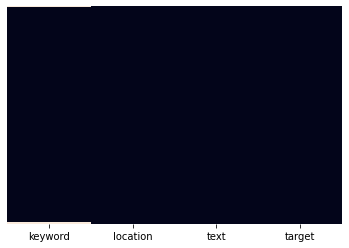

In [247]:
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False)

In [248]:
train_data.keyword.isnull().sum()

61

In [249]:
val_keys = train_data.keyword.value_counts().sort_values()

In [250]:
for i,j in train_data['keyword'].iteritems():
    if(not j in val_keys.index):
        train_data['keyword'][i] = 'random_key'
        
for i,j in test_data['keyword'].iteritems():
    if(not j in val_keys.index):
        test_data['keyword'][i] = 'random_key'

<ipython-input-250-90e2e9576c1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['keyword'][i] = 'random_key'


In [251]:
ps = PorterStemmer()
corpus = []
for i in range(0, train_data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', train_data['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [252]:
ps = PorterStemmer()
corpus_test = []
for i in range(0, test_data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', test_data['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_test.append(review)

In [253]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()

In [254]:
X_test = cv.transform(corpus_test).toarray()

In [255]:
X_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [256]:
X.shape

(7613, 2500)

In [257]:
X = pd.DataFrame(X)

In [258]:
X_test = pd.DataFrame(X_test)

In [259]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
train_data

,keyword,location,text,target
0,random_key,General,Our Deeds are the Reason of this #earthquake M...,1
1,random_key,General,Forest fire near La Ronge Sask. Canada,1
2,random_key,General,All residents asked to 'shelter in place' are ...,1
3,random_key,General,"13,000 people receive #wildfires evacuation or...",1
4,random_key,General,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,random_key,General,Two giant cranes holding a bridge collapse int...,1
7609,random_key,General,@aria_ahrary @TheTawniest The out of control w...,1
7610,random_key,General,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,random_key,General,Police investigating after an e-bike collided ...,1


In [261]:
X = pd.concat([train_data, X], axis=1)

In [262]:
X_test = pd.concat([test_data, X_test], axis=1)

In [263]:
y = X['target']
X = X.drop(['text','target'], axis=1)

In [264]:
X_test = X_test.drop(['text'],axis=1)
X_test

,keyword,location,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3260,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3261,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [265]:
X

,keyword,location,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [266]:
com_data = pd.concat([X,X_test], axis=0, ignore_index=True)
com_data

,keyword,location,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10872,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10873,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10874,random_key,General,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [267]:
com_data = pd.get_dummies(com_data)
com_data

,0,1,2,3,4,5,6,7,8,9,...,location_San Francisco,"location_San Francisco, CA",location_Toronto,location_UK,location_USA,location_United Kingdom,location_United States,"location_Washington, D.C.","location_Washington, DC",location_Worldwide
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [268]:
X = com_data.loc[0:7612, :]
X

,0,1,2,3,4,5,6,7,8,9,...,location_San Francisco,"location_San Francisco, CA",location_Toronto,location_UK,location_USA,location_United Kingdom,location_United States,"location_Washington, D.C.","location_Washington, DC",location_Worldwide
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [269]:
X_test = com_data.loc[7613:, :]
X_test

,0,1,2,3,4,5,6,7,8,9,...,location_San Francisco,"location_San Francisco, CA",location_Toronto,location_UK,location_USA,location_United Kingdom,location_United States,"location_Washington, D.C.","location_Washington, DC",location_Worldwide
7613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [270]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2,random_state=2020)

# print('Shape of train',X_train.shape)
# print("Shape of Validation ",X_test.shape)

In [271]:
from sklearn.ensemble import RandomForestClassifier

RDclassifier = RandomForestClassifier(n_estimators=1000, random_state=0)
RDclassifier.fit(X,y)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [272]:
y_pred = RDclassifier.predict(X_test)

In [273]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test, y_pred))

In [274]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X, y)
y_pred2 = model.predict(X_test)

C:\Users\VISHWANATHAN VIVEK S\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [275]:
# print(confusion_matrix(y_test,y_pred2))
# print(classification_report(y_test,y_pred2))
# print(accuracy_score(y_test, y_pred2))

In [279]:
dict = {'id': id , 'target': y_pred2}
ans = pd.DataFrame(dict)
ans.set_index('id', inplace = True)
ans

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [280]:
ans.to_csv('subs2.csv')